## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
import torchvision.transforms as T
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.semantic_segmentation.controllers.trainer_deeplabv2 import DeepLabV2Trainer
from torchlake.semantic_segmentation.controllers.evaluator_deeplabv2 import DeepLabV2Evaluator
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.deeplabv2 import DeepLabV2, deeplab_v2_style_resnet

from tqdm import tqdm

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setting

In [2]:
artifacts_path = Path("../../artifacts/deeplabv2")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 8
TRAIN_IMAGE_SIZE = 321 # 32k-31
TEST_IMAGE_SIZE = 513 # 32k-31
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
class DownScaleTransform(torch.nn.Module):
    def __init__(self, scale_factor: float):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.interpolate(
            x.expand(1, 1, *x.shape),
            size=TRAIN_IMAGE_SIZE // self.scale_factor + 1,
            mode='nearest',
        ).squeeze()

In [6]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

train_label_transform = T.Compose(
    [
        DownScaleTransform(8),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [7]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
    label_transform=train_label_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [8]:
NUM_WORKERS = get_num_workers()

In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE // 2,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

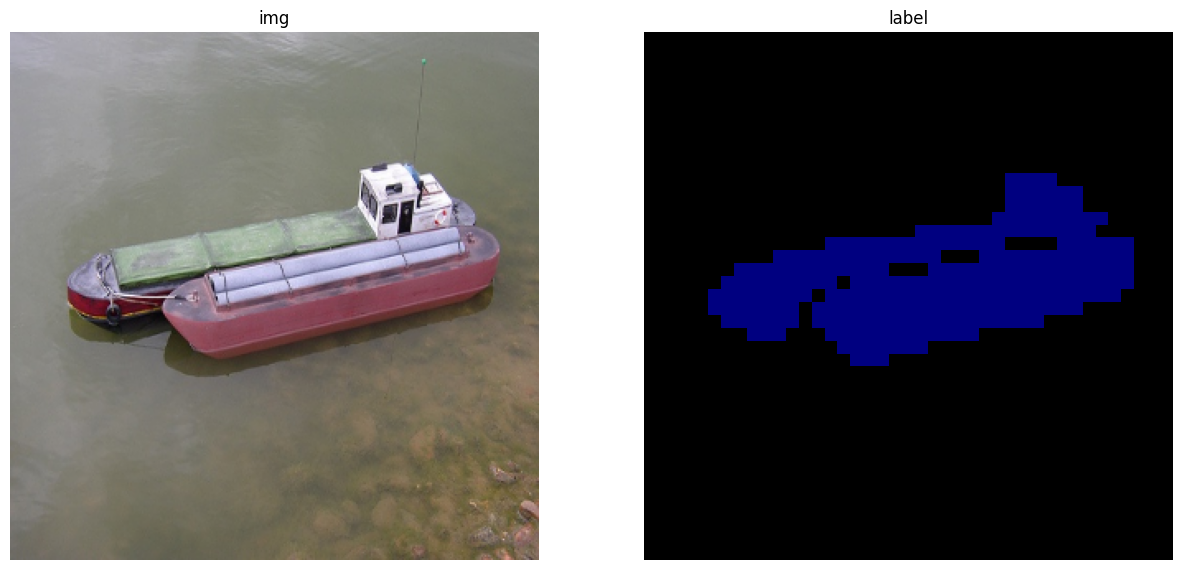

In [10]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [11]:
row = next(iter(train_loader))
for ele in row: print(ele.shape)

torch.Size([4, 3, 321, 321])
torch.Size([4, 41, 41])


# model

In [12]:
backbone = deeplab_v2_style_resnet("resnet101", trainable=True)
model = DeepLabV2(backbone, output_size=NUM_CLASS + 1, enable_shallow_aspp=True).to(DEVICE)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
DeepLabV2                                          --
├─ResNetFeatureExtractor: 1-1                      --
│    └─Sequential: 2-1                             --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    │    └─MaxPool2d: 3-4                         --
│    │    └─Sequential: 3-5                        215,808
│    │    └─Sequential: 3-6                        1,219,584
│    │    └─Sequential: 3-7                        26,090,496
│    │    └─Sequential: 3-8                        14,964,736
│    └─ImageNetNormalization: 2-2                  --
├─Sequential: 1-2                                  --
│    └─ShallowASPP: 2-3                            --
│    │    └─ModuleList: 3-9                        1,548,372
Total params: 44,048,532
Trainable params: 44,048,532
Non-trainable params: 0

# train

## single scale

In [14]:
EPOCHS = 30

In [ ]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [16]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [ ]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 728/728 [02:04<00:00,  5.85it/s]


------------------------------------
Epoch 1
------------------------------------
total: 1.5973e-01 (0.00%)


100%|██████████| 728/728 [02:40<00:00,  4.55it/s]


------------------------------------
Epoch 2
------------------------------------
total: 8.2437e-02 (-48.00%)


100%|██████████| 728/728 [03:09<00:00,  3.83it/s]


------------------------------------
Epoch 3
------------------------------------
total: 5.7460e-02 (-30.00%)


100%|██████████| 728/728 [03:07<00:00,  3.89it/s]


------------------------------------
Epoch 4
------------------------------------
total: 4.7089e-02 (-18.00%)


100%|██████████| 728/728 [03:12<00:00,  3.78it/s]


------------------------------------
Epoch 5
------------------------------------
total: 3.8578e-02 (-18.00%)


100%|██████████| 728/728 [03:08<00:00,  3.87it/s]


------------------------------------
Epoch 6
------------------------------------
total: 3.8037e-02 (-1.00%)


100%|██████████| 728/728 [02:45<00:00,  4.39it/s]


------------------------------------
Epoch 7
------------------------------------
total: 3.2548e-02 (-14.00%)


100%|██████████| 728/728 [02:01<00:00,  5.98it/s]


------------------------------------
Epoch 8
------------------------------------
total: 2.8393e-02 (-13.00%)


100%|██████████| 728/728 [02:01<00:00,  6.00it/s]


------------------------------------
Epoch 9
------------------------------------
total: 2.6855e-02 (-5.00%)


100%|██████████| 728/728 [02:01<00:00,  6.00it/s]


------------------------------------
Epoch 10
------------------------------------
total: 2.3240e-02 (-13.00%)


100%|██████████| 728/728 [02:01<00:00,  6.00it/s]


------------------------------------
Epoch 11
------------------------------------
total: 2.2971e-02 (-1.00%)


100%|██████████| 728/728 [02:01<00:00,  6.01it/s]


------------------------------------
Epoch 12
------------------------------------
total: 2.3883e-02 (4.00%)


100%|██████████| 728/728 [02:01<00:00,  6.00it/s]


------------------------------------
Epoch 13
------------------------------------
total: 1.9882e-02 (-17.00%)


100%|██████████| 728/728 [02:01<00:00,  6.02it/s]


------------------------------------
Epoch 14
------------------------------------
total: 1.7367e-02 (-13.00%)


100%|██████████| 728/728 [02:23<00:00,  5.07it/s]


------------------------------------
Epoch 15
------------------------------------
total: 1.8367e-02 (6.00%)


100%|██████████| 728/728 [02:47<00:00,  4.34it/s]


------------------------------------
Epoch 16
------------------------------------
total: 1.7659e-02 (-4.00%)


100%|██████████| 728/728 [02:01<00:00,  6.01it/s]


------------------------------------
Epoch 17
------------------------------------
total: 1.4914e-02 (-16.00%)


100%|██████████| 728/728 [02:01<00:00,  6.00it/s]


------------------------------------
Epoch 18
------------------------------------
total: 1.4149e-02 (-5.00%)


100%|██████████| 728/728 [02:01<00:00,  6.00it/s]


------------------------------------
Epoch 19
------------------------------------
total: 1.3247e-02 (-6.00%)


100%|██████████| 728/728 [02:01<00:00,  6.00it/s]


------------------------------------
Epoch 20
------------------------------------
total: 1.4599e-02 (10.00%)


100%|██████████| 728/728 [02:01<00:00,  5.99it/s]


------------------------------------
Epoch 21
------------------------------------
total: 1.7690e-02 (21.00%)


100%|██████████| 728/728 [13:10:32<00:00, 65.15s/it]        


------------------------------------
Epoch 22
------------------------------------
total: 1.1817e-02 (-33.00%)


100%|██████████| 728/728 [02:35<00:00,  4.69it/s]


------------------------------------
Epoch 23
------------------------------------
total: 9.9925e-03 (-15.00%)


100%|██████████| 728/728 [02:01<00:00,  6.00it/s]


------------------------------------
Epoch 24
------------------------------------
total: 1.2921e-02 (29.00%)


100%|██████████| 728/728 [02:01<00:00,  6.01it/s]


------------------------------------
Epoch 25
------------------------------------
total: 1.1605e-02 (-10.00%)


100%|██████████| 728/728 [02:01<00:00,  6.00it/s]


------------------------------------
Epoch 26
------------------------------------
total: 1.0213e-02 (-12.00%)


100%|██████████| 728/728 [02:01<00:00,  6.01it/s]


------------------------------------
Epoch 27
------------------------------------
total: 8.3488e-03 (-18.00%)


100%|██████████| 728/728 [02:01<00:00,  6.00it/s]


------------------------------------
Epoch 28
------------------------------------
total: 8.1827e-03 (-2.00%)


100%|██████████| 728/728 [02:02<00:00,  5.95it/s]


------------------------------------
Epoch 29
------------------------------------
total: 8.1698e-03 (0.00%)


100%|██████████| 728/728 [02:01<00:00,  6.01it/s]

------------------------------------
Epoch 30
------------------------------------
total: 6.9789e-03 (-15.00%)


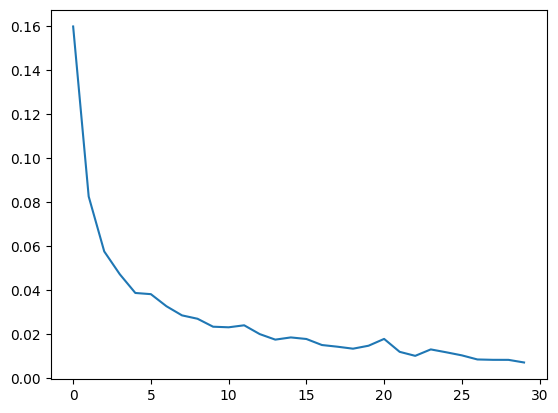

In [ ]:
plt.plot(training_loss)

## multi scale

In [14]:
EPOCHS = 30

In [15]:
trainer = DeepLabV2Trainer(EPOCHS, DEVICE)
trainer.set_multiscales()
trainer.recorder.increment_data_size(len(train_dataset))

In [16]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [18]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


  0%|          | 0/728 [00:00<?, ?it/s]

100%|██████████| 728/728 [03:44<00:00,  3.24it/s]


------------------------------------
Epoch 1
------------------------------------
total: 6.9939e-01 (0.00%)


100%|██████████| 728/728 [03:41<00:00,  3.29it/s]


------------------------------------
Epoch 2
------------------------------------
total: 3.8569e-01 (-45.00%)


100%|██████████| 728/728 [03:41<00:00,  3.29it/s]


------------------------------------
Epoch 3
------------------------------------
total: 2.8306e-01 (-27.00%)


100%|██████████| 728/728 [03:41<00:00,  3.29it/s]


------------------------------------
Epoch 4
------------------------------------
total: 2.3850e-01 (-16.00%)


100%|██████████| 728/728 [04:59<00:00,  2.43it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.9994e-01 (-16.00%)


100%|██████████| 728/728 [05:25<00:00,  2.24it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.8117e-01 (-9.00%)


100%|██████████| 728/728 [05:25<00:00,  2.24it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.6071e-01 (-11.00%)


100%|██████████| 728/728 [05:25<00:00,  2.24it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.4485e-01 (-10.00%)


100%|██████████| 728/728 [05:25<00:00,  2.23it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.5906e-01 (10.00%)


100%|██████████| 728/728 [05:25<00:00,  2.24it/s]


------------------------------------
Epoch 10
------------------------------------
total: 1.2834e-01 (-19.00%)


100%|██████████| 728/728 [05:25<00:00,  2.24it/s]


------------------------------------
Epoch 11
------------------------------------
total: 1.1413e-01 (-11.00%)


100%|██████████| 728/728 [05:26<00:00,  2.23it/s]


------------------------------------
Epoch 12
------------------------------------
total: 1.0780e-01 (-6.00%)


100%|██████████| 728/728 [05:25<00:00,  2.23it/s]


------------------------------------
Epoch 13
------------------------------------
total: 1.0976e-01 (2.00%)


100%|██████████| 728/728 [05:25<00:00,  2.24it/s]


------------------------------------
Epoch 14
------------------------------------
total: 1.1304e-01 (3.00%)


100%|██████████| 728/728 [05:25<00:00,  2.24it/s]


------------------------------------
Epoch 15
------------------------------------
total: 9.9711e-02 (-12.00%)


100%|██████████| 728/728 [04:46<00:00,  2.54it/s]


------------------------------------
Epoch 16
------------------------------------
total: 9.0714e-02 (-9.00%)


100%|██████████| 728/728 [03:41<00:00,  3.28it/s]


------------------------------------
Epoch 17
------------------------------------
total: 8.3266e-02 (-8.00%)


100%|██████████| 728/728 [04:29<00:00,  2.70it/s]


------------------------------------
Epoch 18
------------------------------------
total: 7.9440e-02 (-5.00%)


100%|██████████| 728/728 [05:24<00:00,  2.24it/s]


------------------------------------
Epoch 19
------------------------------------
total: 8.8654e-02 (12.00%)


100%|██████████| 728/728 [04:17<00:00,  2.82it/s]


------------------------------------
Epoch 20
------------------------------------
total: 8.2053e-02 (-7.00%)


100%|██████████| 728/728 [03:45<00:00,  3.22it/s]


------------------------------------
Epoch 21
------------------------------------
total: 7.2636e-02 (-11.00%)


100%|██████████| 728/728 [03:49<00:00,  3.18it/s]


------------------------------------
Epoch 22
------------------------------------
total: 8.1933e-02 (13.00%)


100%|██████████| 728/728 [03:50<00:00,  3.17it/s]


------------------------------------
Epoch 23
------------------------------------
total: 6.7393e-02 (-18.00%)


100%|██████████| 728/728 [03:47<00:00,  3.20it/s]


------------------------------------
Epoch 24
------------------------------------
total: 6.1080e-02 (-9.00%)


100%|██████████| 728/728 [03:52<00:00,  3.13it/s]


------------------------------------
Epoch 25
------------------------------------
total: 5.7990e-02 (-5.00%)


100%|██████████| 728/728 [03:59<00:00,  3.04it/s]


------------------------------------
Epoch 26
------------------------------------
total: 5.7705e-02 (0.00%)


100%|██████████| 728/728 [03:54<00:00,  3.11it/s]


------------------------------------
Epoch 27
------------------------------------
total: 7.8195e-02 (36.00%)


100%|██████████| 728/728 [03:50<00:00,  3.16it/s]


------------------------------------
Epoch 28
------------------------------------
total: 6.2307e-02 (-20.00%)


100%|██████████| 728/728 [05:26<00:00,  2.23it/s]


------------------------------------
Epoch 29
------------------------------------
total: 5.1557e-02 (-17.00%)


100%|██████████| 728/728 [03:54<00:00,  3.10it/s]

------------------------------------
Epoch 30
------------------------------------
total: 4.8935e-02 (-5.00%)


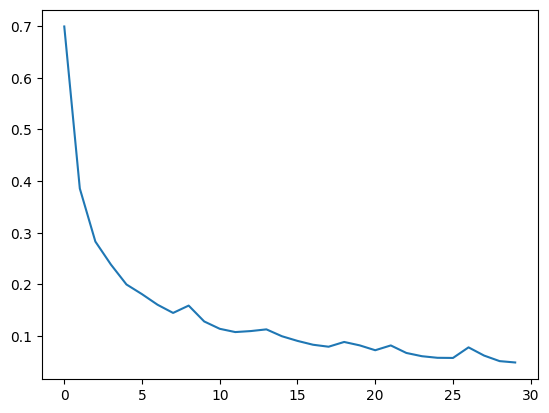

In [19]:
plt.plot(training_loss)

In [16]:
wm = WeightManager(artifacts_path.joinpath('deeplabv2.resnet101{multiscale}.pth').as_posix())

In [17]:
model_path = wm.get_filename(multiscale=".multi-scale" if hasattr(trainer, 'multi_scales') else ".")
model_path

WindowsPath('../../artifacts/deeplabv2/deeplabv2.resnet101.multi-scale.pth')

In [30]:
torch.save(model.state_dict(), model_path)

In [31]:
get_file_size(model_path)

'168.66MiB'

In [18]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### mIOU

In [20]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [21]:
evaluator = ClassificationEvaluator(NUM_CLASS + 1, DEVICE)

In [22]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 158/158 [00:34<00:00,  4.64it/s]


In [22]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.79 
bicycle        : 0.35 
bird           : 0.88 
boat           : 0.73 
bottle         : 0.81 
bus            : 0.84 
car            : 0.84 
cat            : 0.87 
chair          : 0.58 
cow            : 0.84 
diningtable    : 0.83 
dog            : 0.82 
horse          : 0.77 
motorbike      : 0.77 
person         : 0.83 
pottedplant    : 0.5  
sheep          : 0.82 
sofa           : 0.76 
train          : 0.88 
tvmonitor      : 0.81 
----------------------
total          : 0.77 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

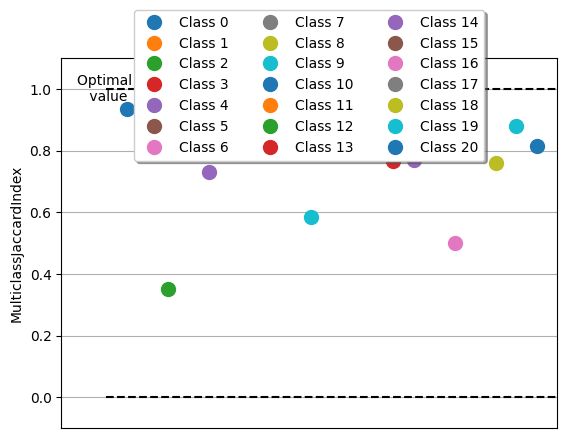

In [23]:
metric.plot()

## multi-scale

In [19]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [20]:
evaluator = DeepLabV2Evaluator(NUM_CLASS + 1, DEVICE)
evaluator.set_multiscales()

In [21]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 158/158 [00:57<00:00,  2.76it/s]


In [22]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.83 
bicycle        : 0.51 
bird           : 0.89 
boat           : 0.79 
bottle         : 0.83 
bus            : 0.91 
car            : 0.87 
cat            : 0.92 
chair          : 0.68 
cow            : 0.85 
diningtable    : 0.89 
dog            : 0.87 
horse          : 0.79 
motorbike      : 0.83 
person         : 0.85 
pottedplant    : 0.6  
sheep          : 0.86 
sofa           : 0.86 
train          : 0.89 
tvmonitor      : 0.88 
----------------------
total          : 0.82 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

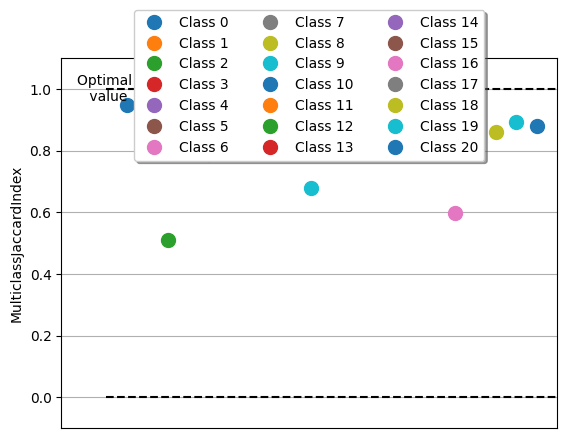

In [24]:
metric.plot()

### for image in dataset

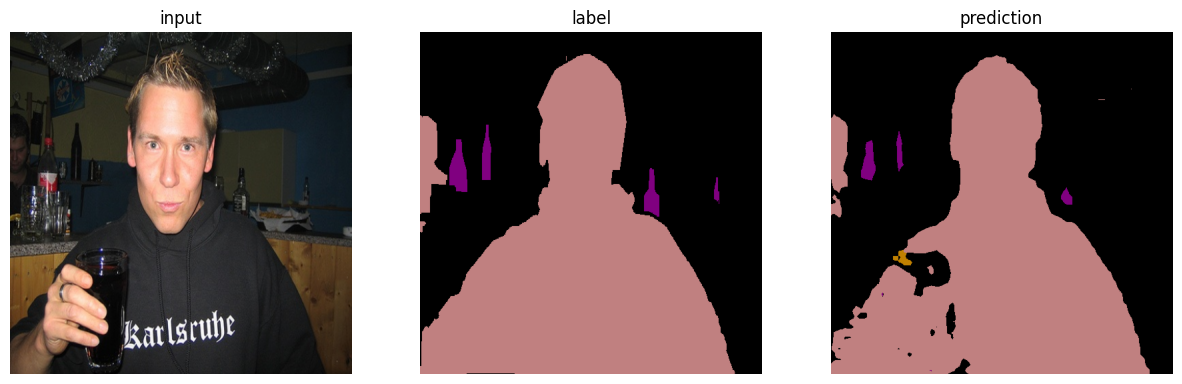

In [24]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

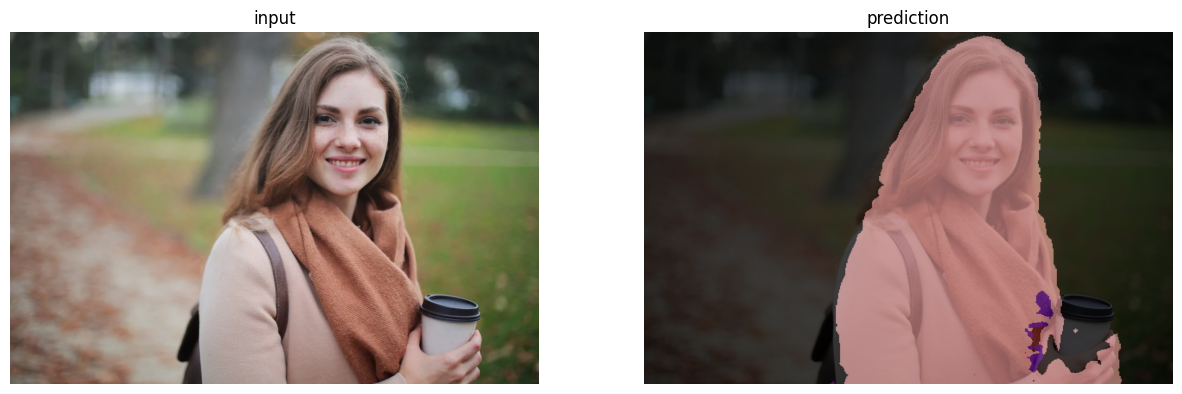

In [25]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )